In [45]:
import json
import csv
import pandas as pd
import numpy as np
import scipy as sci
import keras

from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os
from sklearn import metrics

from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import requests
import tensorflow as tf
from scipy import sparse


In [141]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
import collections
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    

In [6]:
# one-hot cooding of categorical columns

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name]).astype(np.float32)
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    

#Function to normalize columns
def normalize_numeric_minmax(df, name):
    if(df[name].max() > 0):
        df[name] = ((df[name] - df[name].min()) / (df[name].max() - df[name].min())).astype(np.float32)
    else:
        df[name] = df[name].astype(np.float32)

# Loading and Preprocessing the dataset

In [7]:
#Reading and Loading the data into network_df dataframe 
network_df= pd.read_csv('network_intrusion_data.csv')

In [7]:
network_df.shape

(494020, 42)

In [8]:
#Adding column headers to the data in the dataframe
network_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [10]:
network_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.00,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.00,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.00,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.00,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.00,0.0,normal.
5,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.00,0.00,0.00,0.0,normal.
6,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.00,0.00,0.00,0.0,normal.
7,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.00,0.00,0.00,0.0,normal.
8,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.00,0.00,0.00,0.0,normal.
9,0,tcp,http,SF,210,624,0,0,0,0,...,109,1.0,0.0,0.06,0.05,0.00,0.00,0.00,0.0,normal.


In [11]:
network_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'outcome'],
      dtype='object')

In [12]:
network_df.columns.isnull().sum()

0

In [13]:
# Before removing redundant values

print(network_df.outcome.value_counts())

smurf.              280790
neptune.            107201
normal.              97277
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: outcome, dtype: int64


In [9]:
print (network_df.shape)

#Drop any row with missing values
network_df = network_df.dropna()

print (network_df.shape)

#Drop redundant rows
network_df.drop_duplicates(keep='first', inplace=True)

print ("Dataframe shape after removing redundant values{} ".format(network_df.shape))

# Total Number of coumuns are 42

(494020, 42)
(494020, 42)
Dataframe shape after removing redundant values(145585, 42) 


In [15]:
network_df.outcome.value_counts()

normal.             87831
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: outcome, dtype: int64

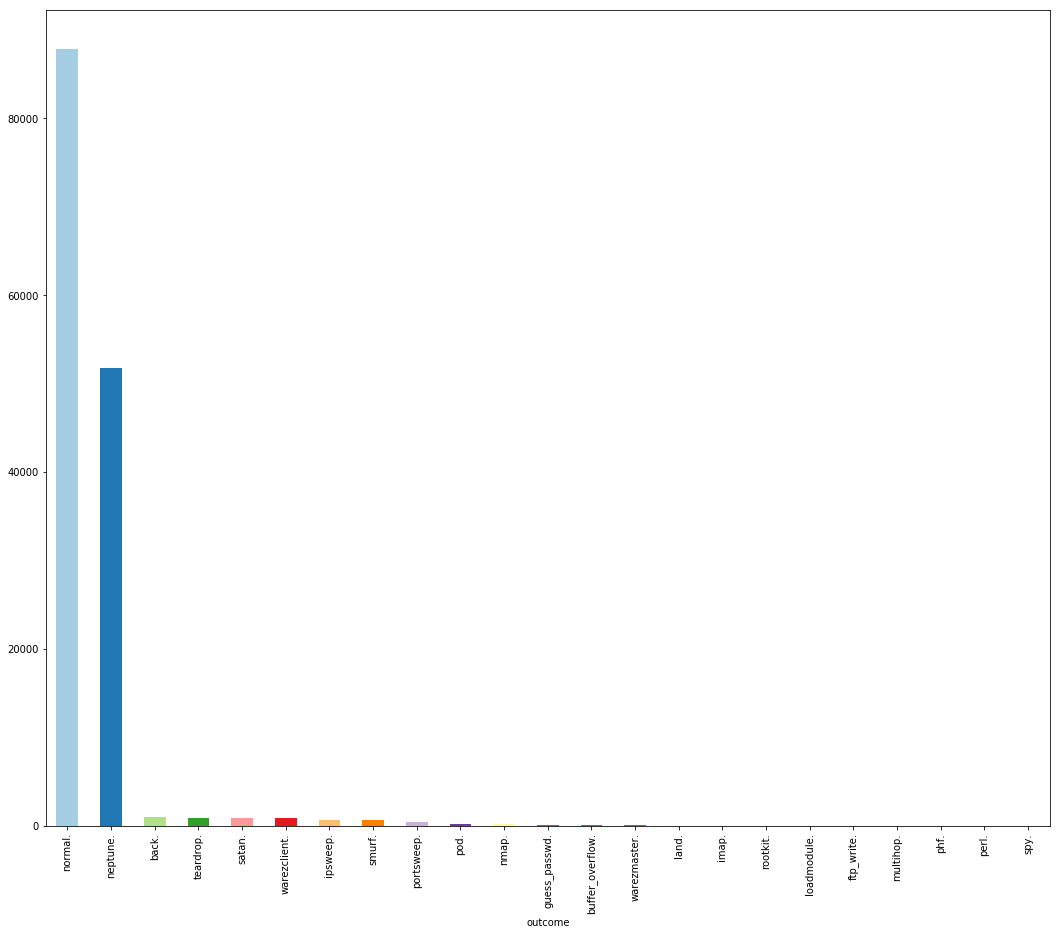

In [16]:
from IPython.display import display
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline
network_df.outcome.groupby(network_df.outcome).count().sort_values()[::-1].plot(kind="bar",figsize=(18, 15),color=[plt.cm.Paired(np.arange(len(network_df['outcome'])))])

In [13]:
network_df_raw = network_df.copy()

In [18]:
network_df.nunique()

duration                        2495
protocol_type                      3
service                           66
flag                              11
src_bytes                       3300
dst_bytes                      10725
land                               2
wrong_fragment                     3
urgent                             4
hot                               22
num_failed_logins                  6
logged_in                          2
num_compromised                   23
root_shell                         2
su_attempted                       3
num_root                          20
num_file_creations                18
num_shells                         3
num_access_files                   7
num_outbound_cmds                  1
is_host_login                      1
is_guest_login                     2
count                            490
srv_count                        470
serror_rate                       92
srv_serror_rate                   51
rerror_rate                       77
s

In [19]:
network_df_raw.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [20]:
# Checking and understanding each column in the dataframe
print(network_df.land.value_counts()) # leave -2
print(network_df.logged_in.value_counts()) # leave -2
print(network_df.wrong_fragment.value_counts()) # one hot
print(network_df.urgent.value_counts()) # one hot -4
print(network_df.hot.value_counts()) # normalize
print(network_df.num_failed_logins.value_counts()) #normalize
print(network_df.num_compromised.value_counts()) # normalize 
print(network_df.root_shell.value_counts()) # leave -2
print(network_df.su_attempted.value_counts()) # one hot -3
print(network_df.num_shells.value_counts()) # one hot-3


0    145565
1        20
Name: land, dtype: int64
0    74032
1    71553
Name: logged_in, dtype: int64
0    144464
3       910
1       211
Name: wrong_fragment, dtype: int64
0    145581
1         2
3         1
2         1
Name: urgent, dtype: int64
0     143628
2        958
28       274
1        255
4        112
6        104
5         51
3         38
14        37
30        28
22        28
19        23
18        13
24        13
20        10
7          5
17         2
12         2
15         1
16         1
10         1
9          1
Name: hot, dtype: int64
0    145522
1        57
2         3
5         1
4         1
3         1
Name: num_failed_logins, dtype: int64
0      144595
1         917
2          24
4          16
3          11
6           3
5           2
7           2
12          1
9           1
11          1
767         1
884         1
16          1
18          1
275         1
21          1
22          1
281         1
38          1
102         1
238         1
13          1
Name: num_c

In [10]:
#Normalize feature input   (27)

normalize_numeric_minmax(network_df,"duration") 
normalize_numeric_minmax(network_df,"src_bytes") 
normalize_numeric_minmax(network_df,"dst_bytes")  
normalize_numeric_minmax(network_df,"hot") 
normalize_numeric_minmax(network_df,"num_failed_logins") 
normalize_numeric_minmax(network_df,"num_compromised") 
normalize_numeric_minmax(network_df,"num_root") 
normalize_numeric_minmax(network_df,"num_file_creations") 
normalize_numeric_minmax(network_df,"num_access_files") 

normalize_numeric_minmax(network_df,"count") 
normalize_numeric_minmax(network_df,"srv_count") 
normalize_numeric_minmax(network_df,"serror_rate") 
normalize_numeric_minmax(network_df,"rerror_rate") 
normalize_numeric_minmax(network_df,"srv_rerror_rate")  
normalize_numeric_minmax(network_df,"same_srv_rate") 
normalize_numeric_minmax(network_df,"diff_srv_rate") 
normalize_numeric_minmax(network_df,"srv_diff_host_rate") 
normalize_numeric_minmax(network_df,"dst_host_count") 
normalize_numeric_minmax(network_df,"dst_host_srv_count") 
normalize_numeric_minmax(network_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(network_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(network_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(network_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(network_df,"dst_host_serror_rate") 
normalize_numeric_minmax(network_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(network_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(network_df,"dst_host_srv_rerror_rate") 

In [11]:
#One hot coding discrete values (7)
encode_text_dummy(network_df,"protocol_type") 
encode_text_dummy(network_df,"service") 
encode_text_dummy(network_df,"flag")
encode_text_dummy(network_df,"wrong_fragment") 
encode_text_dummy(network_df,"urgent") 
encode_text_dummy(network_df,"su_attempted") 
encode_text_dummy(network_df,"num_shells")  

*** Label concoding the output feature as normal = 0 and threat = 1 *** 

In [15]:
# create a function binary_encode_network to label encode the output feature
binary_encode_network = lambda x: 0 if x == 'normal.' else 1

In [16]:
label_outcome_df = network_df[['outcome']]
network_outcome_df = network_df[['outcome']]
network_df.drop(['outcome'],inplace=True, axis=1)
print(network_df.shape)
print(label_outcome_df.shape)

(145585, 127)
(145585, 1)


In [164]:
label_outcome_df = network_outcome_df.copy()

In [17]:
#Label Encode the output column 
label_outcome_df['outcome'] = label_outcome_df['outcome'].apply(binary_encode_network)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
network_df = network_df.astype('float32')
label_outcome_df = label_outcome_df.astype('float32')

In [20]:
print(label_outcome_df.outcome.value_counts())

0.0    87831
1.0    57754
Name: outcome, dtype: int64


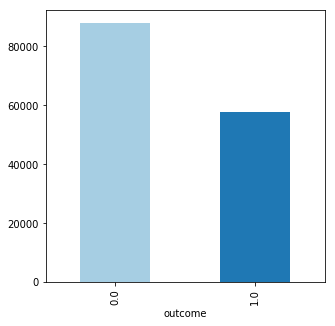

In [36]:
label_outcome_df.outcome.groupby(label_outcome_df.outcome).count().sort_values()[::-1].plot(kind="bar",figsize=(5, 5),color=[plt.cm.Paired(np.arange(len(label_outcome_df['outcome'])))])

*** Splitting the data ***

In [310]:
#Split for training and testing
x_train, x_test, y_train, y_test = train_test_split(network_df.values, label_outcome_df['outcome'].values, test_size=0.2, random_state=42)

In [311]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(116468, 127)
(116468,)
(29117, 127)
(29117,)


# Logistic Regression

In [213]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_train, y_train)

y_pred_logistic = Log_reg_model.predict(x_test)

In [219]:
for i in range(100):
    print(" Actual Value: {}, predicted Value: {}".format(y_test[i],y_pred_logistic[i]))

 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1

In [368]:
# Metrics
from sklearn import metrics
score_acc_log = metrics.accuracy_score(y_test, y_pred_logistic)
print("Accuracy score: {}".format(score_acc_log))

score_precision_log = metrics.precision_score(y_test, y_pred_logistic, average= "weighted")
print("Precision score: {}".format(score_precision_log))

score_recall_log = metrics.recall_score(y_test, y_pred_logistic, average= "weighted")
print("Recall score: {}".format(score_recall_log))

score_f1_log = metrics.f1_score(y_test, y_pred_logistic, average= "weighted")
print("F1 score: {}".format(score_f1_log))

Accuracy score: 0.9856097812274616
Precision score: 0.9856174290684699
Recall score: 0.9856097812274616
F1 score: 0.9855969338792709


In [216]:
logistic_cm = confusion_matrix(y_test, y_pred_logistic)
print(logistic_cm)

[[17478   111]
 [  248 11280]]


Plotting confusion matrix


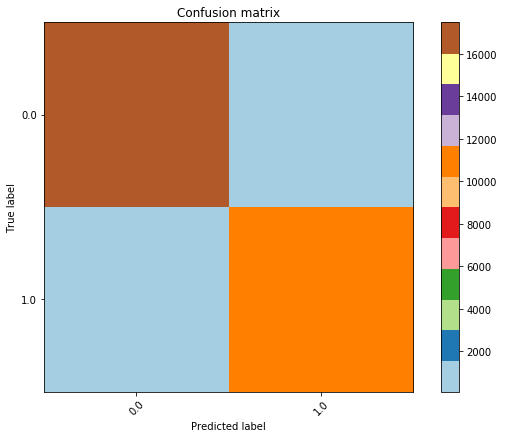

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99     17589
        1.0       0.99      0.98      0.98     11528

avg / total       0.99      0.99      0.99     29117



In [217]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(logistic_cm,label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(y_test, y_pred_logistic))

In [218]:
y_test.shape

(29117,)

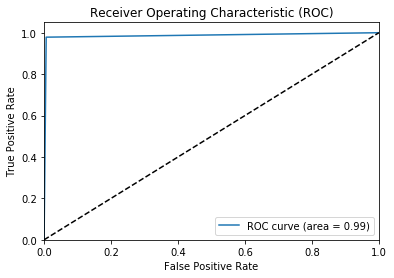

In [214]:
plot_roc(y_pred_logistic,y_test)

# Nearest Neighbor

In [313]:
#implementing Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(x_train, y_train) 

y_pred_knn = knn.predict(x_test)

In [314]:
# Metrics
from sklearn import metrics

score_knn_acc = metrics.accuracy_score(y_test, y_pred_knn)
print("Accuracy score: {}".format(score_knn_acc))

score_knn_precision = metrics.precision_score(y_test, y_pred_knn, average= "weighted")
print("Precision score: {}".format(score_knn_precision))

score_knn_recall = metrics.recall_score(y_test, y_pred_knn, average= "weighted")
print("Recall score: {}".format(score_knn_recall))

score_knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
print("F1 score: {}".format(score_knn_f1))

Accuracy score: 0.9983171343201566
Precision score: 0.9983184986240411
Recall score: 0.9983171343201566
F1 score: 0.9983173724454629


In [315]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
print(cm_knn)

[[17555    34]
 [   15 11513]]


Plotting confusion matrix


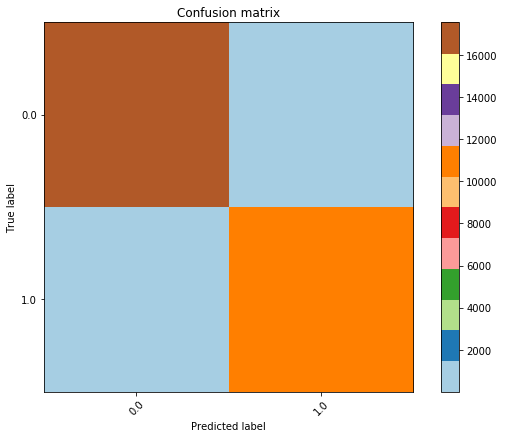

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     17589
        1.0       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



In [316]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_knn,label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(y_test, y_pred_knn))

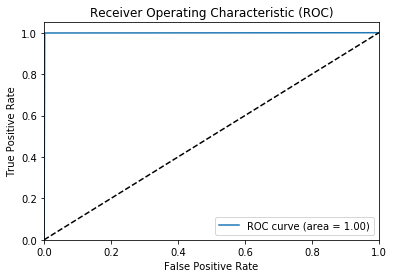

In [317]:
plot_roc(y_pred_knn,y_test)

# SVM

In [318]:
# SVM
from sklearn.svm import SVC

svm_model = SVC(kernel="linear")
# kernel = rbf

svm_model.fit(x_train, y_train)

y_pred_svm = svm_model.predict(x_test)

In [319]:
# Metrics

score_svm_acc = metrics.accuracy_score(y_test, y_pred_svm)
print("Accuracy score: {}".format(score_svm_acc))

score_svm_precision = metrics.precision_score(y_test, y_pred_svm, average= "weighted")
print("Precision score: {}".format(score_svm_precision))

score_svm_recall = metrics.recall_score(y_test, y_pred_svm, average= "weighted")
print("Recall score: {}".format(score_svm_recall))

score_svm_f1 = metrics.f1_score(y_test, y_pred_svm, average= "weighted")
print("F1 score: {}".format(score_svm_f1))

Accuracy score: 0.9907957550571831
Precision score: 0.990796867441711
Recall score: 0.9907957550571831
F1 score: 0.9907913022187553


In [320]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(cm_svm)

[[17487   102]
 [  166 11362]]


Plotting confusion matrix


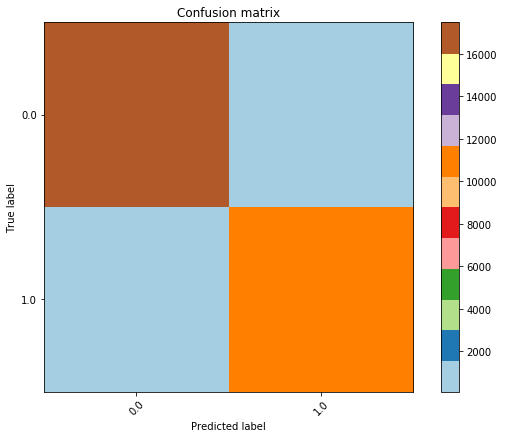

In [321]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_svm, label_outcome_df['outcome'].unique())
plt.show()

In [366]:
print(classification_report(y_test, y_pred_svm))

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99     17589
        1.0       0.99      0.99      0.99     11528

avg / total       0.99      0.99      0.99     29117



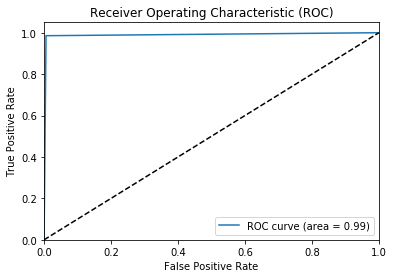

In [367]:
plot_roc(y_pred_svm,y_test)

# Gaussian Naive Bayes 

In [322]:
#GNB
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()

gnb_model.fit(x_train, y_train)

y_pred_gnb = gnb_model.predict(x_test)

In [323]:
# Metrics

score_gnb_acc = metrics.accuracy_score(y_test, y_pred_gnb)
print("Accuracy score: {}".format(score_gnb_acc))

score_gnb_precision = metrics.precision_score(y_test, y_pred_gnb, average= "weighted")
print("Precision score: {}".format(score_gnb_precision))

score_gnb_recall = metrics.recall_score(y_test, y_pred_gnb, average= "weighted")
print("Recall score: {}".format(score_gnb_recall))

score_gnb_f1 = metrics.f1_score(y_test, y_pred_gnb, average= "weighted")
print("F1 score: {}".format(score_gnb_f1))

Accuracy score: 0.918501219219013
Precision score: 0.9269643663217237
Recall score: 0.918501219219013
F1 score: 0.9165476101943393


In [324]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
print(cm_gnb)

[[17526    63]
 [ 2310  9218]]


Plotting confusion matrix


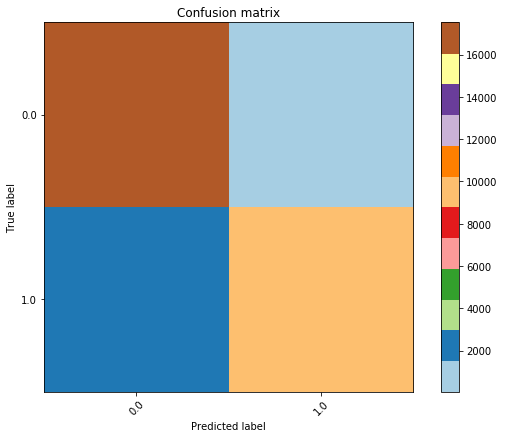

             precision    recall  f1-score   support

        0.0       0.88      1.00      0.94     17589
        1.0       0.99      0.80      0.89     11528

avg / total       0.93      0.92      0.92     29117



In [325]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_gnb, label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(y_test, y_pred_gnb))

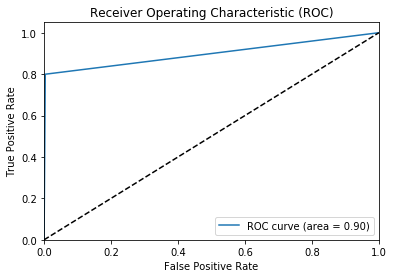

In [326]:
pred_gnb = gnb_model.predict(x_test)
pred_gnb = pred_gnb[:]
plot_roc(pred_gnb,y_test)

# Fully-Connected Neural Networks

## ReLu - Activation Function
*** One hot encoding the output feature *** 

In [185]:
outcome_one_hot_df = label_outcome_df.copy()
print(outcome_one_hot_df)

        outcome
0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
6           0.0
7           0.0
8           0.0
9           0.0
10          0.0
11          0.0
12          0.0
13          0.0
14          0.0
15          0.0
16          0.0
17          0.0
18          0.0
19          0.0
20          0.0
21          0.0
22          0.0
23          0.0
24          0.0
25          0.0
26          0.0
27          0.0
28          0.0
29          0.0
...         ...
493990      0.0
493991      0.0
493992      0.0
493993      0.0
493994      0.0
493995      0.0
493996      0.0
493997      0.0
493998      0.0
493999      0.0
494000      0.0
494001      0.0
494002      0.0
494003      0.0
494004      0.0
494005      0.0
494006      0.0
494007      0.0
494008      0.0
494009      0.0
494010      0.0
494011      0.0
494012      0.0
494013      0.0
494014      0.0
494015      0.0
494016      0.0
494017      0.0
494018      0.0
494019      0.0

[145585

In [195]:
#One hot coding the output feature
encode_text_dummy(outcome_one_hot_df,"outcome")

In [196]:
outcome_one_hot_df.shape

(145585, 2)

In [197]:
print(outcome_one_hot_df.values)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [199]:
#Split for training and testing
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(network_df.values,outcome_one_hot_df.values, test_size=0.2, random_state=42)

In [200]:
print(x_train_nn.shape)
print(y_train_nn.shape)
print(x_test_nn.shape)
print(y_test_nn.shape)

(116468, 127)
(116468, 2)
(29117, 127)
(29117, 2)


In [201]:
# set up checkpointer
checkpoint_relu_nn = ModelCheckpoint(filepath="./best_fully_relu_nn.hdf5", verbose=1, save_best_only=True)

In [202]:
# relu adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_nn_relu = Sequential()
    model_nn_relu.add(Dense(128, input_dim=x_train_nn.shape[1], activation='relu')) # hidden 1
    model_nn_relu.add(Dense(64, activation='relu')) # hidden 2
    model_nn_relu.add(Dense(34, activation='relu'))# hidden 3
    model_nn_relu.add(Dense(8, activation='relu'))# hidden 4
    model_nn_relu.add(Dense(y_test_nn.shape[1],activation='softmax'))
    
    model_nn_relu.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    model_nn_relu.fit(x_train_nn,y_train_nn,batch_size=128,validation_data=(x_test_nn,y_test_nn),callbacks=[monitor,checkpoint_relu_nn ],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_nn_relu.load_weights('./best_fully_relu_nn.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 9s - loss: 0.0451 - val_loss: 0.0118

Epoch 00001: val_loss improved from inf to 0.01177, saving model to ./best_fully_relu_nn.hdf5
Epoch 2/100
 - 5s - loss: 0.0112 - val_loss: 0.0074

Epoch 00002: val_loss improved from 0.01177 to 0.00741, saving model to ./best_fully_relu_nn.hdf5
Epoch 3/100
 - 3s - loss: 0.0079 - val_loss: 0.0068

Epoch 00003: val_loss improved from 0.00741 to 0.00684, saving model to ./best_fully_relu_nn.hdf5
Epoch 4/100
 - 6s - loss: 0.0068 - val_loss: 0.0061

Epoch 00004: val_loss improved from 0.00684 to 0.00608, saving model to ./best_fully_relu_nn.hdf5
Epoch 5/100
 - 8s - loss: 0.0062 - val_loss: 0.0055

Epoch 00005: val_loss improved from 0.00608 to 0.00549, saving model to ./best_fully_relu_nn.hdf5
Epoch 6/100
 - 7s - loss: 0.0058 - val_loss: 0.0055

Epoch 00006: val_loss did not improve from 0.00549
Epoch 7/100
 - 7s - loss: 0.0059 - val_loss: 0.0050

Epoch 00007: val_loss improved from 0.0

 - 14s - loss: 0.0378 - val_loss: 0.0108

Epoch 00001: val_loss did not improve from 0.00443
Epoch 2/100
 - 10s - loss: 0.0104 - val_loss: 0.0070

Epoch 00002: val_loss did not improve from 0.00443
Epoch 3/100
 - 8s - loss: 0.0075 - val_loss: 0.0082

Epoch 00003: val_loss did not improve from 0.00443
Epoch 4/100
 - 8s - loss: 0.0072 - val_loss: 0.0055

Epoch 00004: val_loss did not improve from 0.00443
Epoch 5/100
 - 8s - loss: 0.0067 - val_loss: 0.0062

Epoch 00005: val_loss did not improve from 0.00443
Epoch 6/100
 - 7s - loss: 0.0059 - val_loss: 0.0052

Epoch 00006: val_loss did not improve from 0.00443
Epoch 7/100
 - 9s - loss: 0.0056 - val_loss: 0.0051

Epoch 00007: val_loss did not improve from 0.00443
Epoch 00007: early stopping
Training finished...Loading the best model



In [203]:
pred_nn_relu = model_nn_relu.predict(x_test_nn)
pred_nn_relu

array([[9.9995887e-01, 4.1105672e-05],
       [2.4136446e-07, 9.9999976e-01],
       [9.9995708e-01, 4.2910313e-05],
       ...,
       [1.1918085e-06, 9.9999881e-01],
       [7.4176761e-08, 9.9999988e-01],
       [9.7518019e-08, 9.9999988e-01]], dtype=float32)

In [204]:
pred_nn_relu = np.argmax(pred_nn_relu,axis=1)
pred_nn_relu

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [205]:
y_test_nn

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [206]:
actual_nn_relu = np.argmax(y_test_nn,axis=1)
actual_nn_relu

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [207]:
# Metrics

#score_log_loss = metrics.log_loss(y_test_nn, model_nn_relu.predict(x_test_nn))
#print("Log Loss: {}".format(score_log_loss))

score_nn_acc_relu = metrics.accuracy_score(actual_nn_relu, pred_nn_relu)
print("Accuracy score: {}".format(score_nn_acc_relu))

score_nn_precision_relu = metrics.precision_score(actual_nn_relu, pred_nn_relu, average= "weighted")
print("Precision score: {}".format(score_nn_precision_relu))

score_nn_recall_relu = metrics.recall_score(actual_nn_relu, pred_nn_relu, average= "weighted")
print("Recall score: {}".format(score_nn_recall_relu))

score_nn_f1_relu = metrics.f1_score(actual_nn_relu, pred_nn_relu, average= "weighted")
print("F1 score: {}".format(score_nn_f1_relu))



Accuracy score: 0.9986605762956349
Precision score: 0.9986605587356417
Recall score: 0.9986605762956349
F1 score: 0.9986605662844542


In [208]:
cm_nn_relu = confusion_matrix(actual_nn_relu, pred_nn_relu)
print(cm_nn_relu)

[[17570    19]
 [   20 11508]]


Plotting confusion matrix


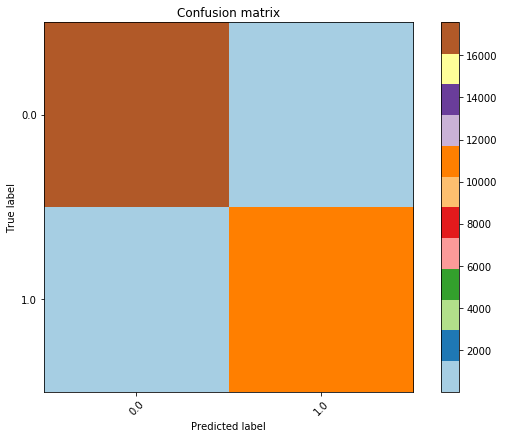

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



In [209]:
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm_nn_relu,label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(actual_nn_relu,pred_nn_relu))

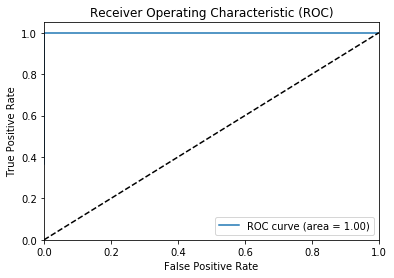

In [169]:
pred_nn_relu = model_nn_relu.predict(x_test_nn)
pred_nn_relu = pred_nn_relu[:,1]
plot_roc(pred_nn_relu,actual_nn_relu)

## Tanh

In [192]:
# set up checkpointer
checkpoint_tanh = ModelCheckpoint(filepath="./best_weights_tanh_nn.hdf5", verbose=1, save_best_only=True)

In [193]:
# tanh adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_nn_tanh = Sequential()
    model_nn_tanh.add(Dense(128, input_dim=x_train_nn.shape[1], activation='tanh')) # hidden 1
    model_nn_tanh.add(Dense(64, activation='tanh'))# hidden 2
    model_nn_tanh.add(Dense(34, activation='tanh'))# hidden 3
    model_nn_tanh.add(Dense(8, activation='tanh'))# hidden 4
    model_nn_tanh.add(Dense(y_test_nn.shape[1],activation='softmax'))
    
    model_nn_tanh.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    model_nn_tanh.fit(x_train_nn,y_train_nn,batch_size=128,validation_data=(x_test_nn,y_test_nn),callbacks=[monitor,checkpoint_tanh ],verbose=2,epochs=100)
    
print('Training Completed .Loading the best model') 
print()
model_nn_tanh.load_weights('./best_weights_tanh_nn.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 22s - loss: 0.0445 - val_loss: 0.0213

Epoch 00001: val_loss improved from inf to 0.02130, saving model to ./best_weights_tanh_nn.hdf5
Epoch 2/100
 - 12s - loss: 0.0169 - val_loss: 0.0102

Epoch 00002: val_loss improved from 0.02130 to 0.01020, saving model to ./best_weights_tanh_nn.hdf5
Epoch 3/100
 - 12s - loss: 0.0103 - val_loss: 0.0096

Epoch 00003: val_loss improved from 0.01020 to 0.00957, saving model to ./best_weights_tanh_nn.hdf5
Epoch 4/100
 - 13s - loss: 0.0093 - val_loss: 0.0074

Epoch 00004: val_loss improved from 0.00957 to 0.00735, saving model to ./best_weights_tanh_nn.hdf5
Epoch 5/100
 - 13s - loss: 0.0090 - val_loss: 0.0072

Epoch 00005: val_loss improved from 0.00735 to 0.00723, saving model to ./best_weights_tanh_nn.hdf5
Epoch 6/100
 - 9s - loss: 0.0076 - val_loss: 0.0083

Epoch 00006: val_loss did not improve from 0.00723
Epoch 7/100
 - 13s - loss: 0.0072 - val_loss: 0.0079

Epoch 00007: val_loss d

 - 10s - loss: 0.0078 - val_loss: 0.0072

Epoch 00006: val_loss did not improve from 0.00599
Epoch 7/100
 - 8s - loss: 0.0075 - val_loss: 0.0078

Epoch 00007: val_loss did not improve from 0.00599
Epoch 00007: early stopping
9
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 21s - loss: 0.0508 - val_loss: 0.0262

Epoch 00001: val_loss did not improve from 0.00599
Epoch 2/100
 - 10s - loss: 0.0191 - val_loss: 0.0115

Epoch 00002: val_loss did not improve from 0.00599
Epoch 3/100
 - 9s - loss: 0.0120 - val_loss: 0.0121

Epoch 00003: val_loss did not improve from 0.00599
Epoch 4/100
 - 8s - loss: 0.0096 - val_loss: 0.0173

Epoch 00004: val_loss did not improve from 0.00599
Epoch 5/100
 - 8s - loss: 0.0096 - val_loss: 0.0097

Epoch 00005: val_loss did not improve from 0.00599
Epoch 6/100
 - 11s - loss: 0.0081 - val_loss: 0.0074

Epoch 00006: val_loss did not improve from 0.00599
Epoch 7/100
 - 11s - loss: 0.0075 - val_loss: 0.0066

Epoch 00007: val_loss did not improve fro

In [194]:
pred_nn_tanh = model_nn_tanh.predict(x_test_nn)
pred_nn_tanh

array([[9.9995899e-01, 4.0998799e-05],
       [6.7986525e-04, 9.9932015e-01],
       [9.9991333e-01, 8.6664440e-05],
       ...,
       [2.2297516e-03, 9.9777031e-01],
       [2.4416409e-05, 9.9997556e-01],
       [2.3897814e-05, 9.9997616e-01]], dtype=float32)

In [195]:
pred_nn_tanh = np.argmax(pred_nn_tanh,axis=1)
pred_nn_tanh

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [197]:
y_test_nn

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [198]:
actual_nn_tanh = np.argmax(y_test_nn,axis=1)
actual_nn_tanh


array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [199]:
# Metrics

score_nn_acc_tanh = metrics.accuracy_score(actual_nn_tanh, pred_nn_tanh)
print("Accuracy score: {}".format(score_nn_acc_tanh))

score_nn_precision_tanh = metrics.precision_score(actual_nn_tanh, pred_nn_tanh, average= "weighted")
print("Precision score: {}".format(score_nn_precision_tanh))

score_nn_recall_tanh = metrics.recall_score(actual_nn_tanh, pred_nn_tanh, average= "weighted")
print("Recall score: {}".format(score_nn_recall_tanh))

score_nn_f1_tanh = metrics.f1_score(actual_nn_tanh, pred_nn_tanh, average= "weighted")
print("F1 score: {}".format(score_nn_f1_tanh))

Accuracy score: 0.9984888553078958
Precision score: 0.9984888753056264
Recall score: 0.9984888553078958
F1 score: 0.9984887421783242


In [200]:
cm_nn_tanh = confusion_matrix(actual_nn_tanh, pred_nn_tanh)
print(cm_nn_tanh)

[[17572    17]
 [   27 11501]]


Plotting confusion matrix


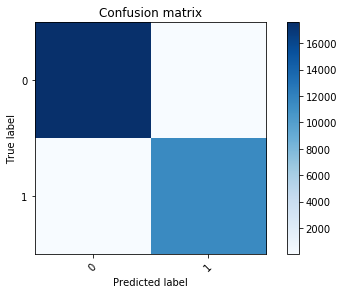

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



In [201]:
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm_nn_tanh,label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(actual_nn_tanh,pred_nn_tanh))

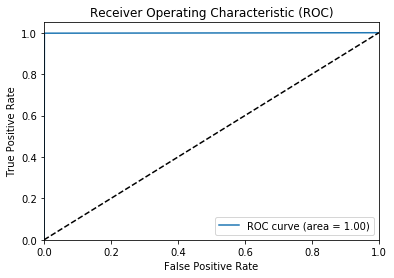

In [202]:
plot_roc(pred_nn_tanh,actual_nn_tanh)

## Sigmoid

In [173]:
# set up checkpointer
checkpoint_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid_nn.hdf5", verbose=1, save_best_only=True)

In [174]:
# relu adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_nn_sig = Sequential()
    model_nn_sig.add(Dense(128, input_dim=x_train_nn.shape[1], activation='sigmoid'))
    model_nn_sig.add(Dense(64, activation='sigmoid'))
    model_nn_sig.add(Dense(34, activation='sigmoid'))
    model_nn_sig.add(Dense(8, activation='sigmoid'))
    model_nn_sig.add(Dense(y_test_nn.shape[1],activation='softmax'))
    
    model_nn_sig.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    model_nn_sig.fit(x_train_nn,y_train_nn,batch_size=128,validation_data=(x_test_nn,y_test_nn),callbacks=[monitor,checkpoint_sigmoid ],verbose=2,epochs=100)
    
print('Training Completed .Loading the best model') 
print()
model_nn_sig.load_weights('./best_weights_sigmoid_nn.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 15s - loss: 0.1659 - val_loss: 0.0715

Epoch 00001: val_loss improved from inf to 0.07149, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 2/100
 - 9s - loss: 0.0637 - val_loss: 0.0485

Epoch 00002: val_loss improved from 0.07149 to 0.04846, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 3/100
 - 10s - loss: 0.0501 - val_loss: 0.0450

Epoch 00003: val_loss improved from 0.04846 to 0.04499, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 4/100
 - 7s - loss: 0.0472 - val_loss: 0.0440

Epoch 00004: val_loss improved from 0.04499 to 0.04397, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 5/100
 - 8s - loss: 0.0467 - val_loss: 0.0428

Epoch 00005: val_loss improved from 0.04397 to 0.04281, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 6/100
 - 9s - loss: 0.0459 - val_loss: 0.0423

Epoch 00006: val_loss improved from 0.04281 to 0.04225, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 7/100
 

 - 22s - loss: 0.1420 - val_loss: 0.0629

Epoch 00001: val_loss did not improve from 0.04225
Epoch 2/100
 - 13s - loss: 0.0622 - val_loss: 0.0534

Epoch 00002: val_loss did not improve from 0.04225
Epoch 3/100
 - 10s - loss: 0.0503 - val_loss: 0.0528

Epoch 00003: val_loss did not improve from 0.04225
Epoch 4/100
 - 12s - loss: 0.0493 - val_loss: 0.0456

Epoch 00004: val_loss did not improve from 0.04225
Epoch 5/100
 - 13s - loss: 0.0481 - val_loss: 0.0470

Epoch 00005: val_loss did not improve from 0.04225
Epoch 6/100
 - 11s - loss: 0.0482 - val_loss: 0.0444

Epoch 00006: val_loss did not improve from 0.04225
Epoch 7/100
 - 11s - loss: 0.0478 - val_loss: 0.0452

Epoch 00007: val_loss did not improve from 0.04225
Epoch 8/100
 - 11s - loss: 0.0478 - val_loss: 0.0470

Epoch 00008: val_loss did not improve from 0.04225
Epoch 9/100
 - 12s - loss: 0.0474 - val_loss: 0.0442

Epoch 00009: val_loss did not improve from 0.04225
Epoch 00009: early stopping
9
Train on 116468 samples, validate on 

In [183]:
pred_nn_sig = model_nn_sig.predict(x_test_nn)
pred_nn_sig

array([[0.9871989 , 0.01280108],
       [0.00163571, 0.99836427],
       [0.9871492 , 0.0128508 ],
       ...,
       [0.00123062, 0.99876934],
       [0.00121293, 0.9987871 ],
       [0.00121302, 0.998787  ]], dtype=float32)

In [184]:
pred_nn_sig = np.argmax(pred_nn_sig,axis=1)
pred_nn_sig

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [185]:
y_test_nn

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [186]:
actual_nn_sig = np.argmax(y_test_nn,axis=1)
actual_nn_sig


array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [187]:
# Metrics

score_nn_acc_sig = metrics.accuracy_score(actual_nn_sig, pred_nn_sig)
print("Accuracy score: {}".format(score_nn_acc_sig))

score_nn_precision_sig = metrics.precision_score(actual_nn_sig, pred_nn_sig, average= "weighted")
print("Precision score: {}".format(score_nn_precision_sig))

score_nn_recall_sig = metrics.recall_score(actual_nn_sig, pred_nn_sig, average= "weighted")
print("Recall score: {}".format(score_nn_recall_sig))

score_nn_f1_sig = metrics.f1_score(actual_nn_sig, pred_nn_sig, average= "weighted")
print("F1 score: {}".format(score_nn_f1_sig))

Accuracy score: 0.99179173678607
Precision score: 0.9918508443405211
Recall score: 0.99179173678607
F1 score: 0.9917801405355152


In [188]:
cm_nn_sig = confusion_matrix(actual_nn_sig, pred_nn_sig)
print(cm_nn_sig)

[[17561    28]
 [  211 11317]]


Plotting confusion matrix


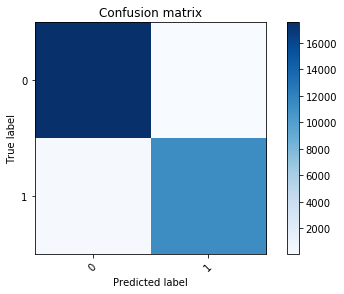

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     17589
          1       1.00      0.98      0.99     11528

avg / total       0.99      0.99      0.99     29117



In [189]:
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm_nn_sig,label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(actual_nn_sig,pred_nn_sig))

In [207]:
actual_nn_sig[:10]

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

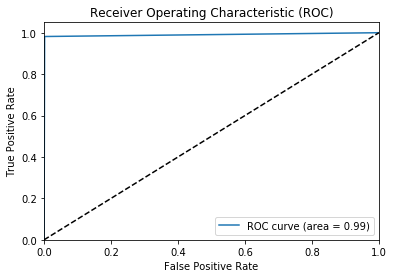

In [190]:
plot_roc(pred_nn_sig,actual_nn_sig)

# Convolutional Neural Network

In [25]:
#Split for train and test

x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = train_test_split(network_df.values,outcome_one_hot_df.values,test_size=0.2, random_state=42)

In [26]:
print(x_train_cnn.shape)
print(y_train_cnn.shape)
print(x_test_cnn.shape)
print(y_test_cnn.shape)

(116468, 127)
(116468, 2)
(29117, 127)
(29117, 2)


In [27]:
# reshaping the x_train and x_test to image form to be used in CNN 2D
x_train_cnn = x_train_cnn.reshape(x_train_cnn.shape[0], 1, x_train_cnn.shape[1], 1)
x_test_cnn = x_test_cnn.reshape(x_test_cnn.shape[0], 1, x_test_cnn.shape[1], 1)

In [28]:
print(x_train_cnn.shape)
print(y_train_cnn.shape)
print(x_test_cnn.shape)
print(y_test_cnn.shape)

(116468, 1, 127, 1)
(116468, 2)
(29117, 1, 127, 1)
(29117, 2)


In [33]:
checkpoint_cnn = ModelCheckpoint(filepath="./best_weights_cnn.hdf5", verbose=1, save_best_only=True)


In [34]:
#input_shape: should be the shape of 1 sample i.e [rows,cols,1]
input_shape = x_train_cnn[0].shape
input_shape

(1, 127, 1)

In [36]:
# CNN 2D

for i in range(3):
    print(i)

    cnn = Sequential()

# Building Conv2D layer 1
    cnn.add(Conv2D(32, kernel_size=(1,3), strides=(1,1), padding='valid',
                     activation='relu',
                     input_shape=input_shape))
# Max pool layer
    cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))    
    
    
# Building Conv2D layer 2
    cnn.add(Conv2D(64, kernel_size=(1,3),strides=(1, 1), activation='relu'))
# Max pool layer
    cnn.add(MaxPooling2D(pool_size=(1,2), strides=None))

# Drop out layer 
    cnn.add(Dropout(0.25))
    
# Flatten
    cnn.add(Flatten())
    
# Fully Connected layer 1

    cnn.add(Dense(128, activation='relu'))
    
# Drop out layer
    cnn.add(Dropout(0.30))
    
    
# Fully Connected layer 2

    cnn.add(Dense(64, activation='relu'))
# Drop out layer
    cnn.add(Dropout(0.50))
    
# output Layer
    cnn.add(Dense(2, activation='softmax'))

# Compile

    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    cnn.fit(x_train_cnn, y_train_cnn, 
            batch_size=128, 
            callbacks=[monitor,checkpoint_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test_cnn, y_test_cnn))

print('Training finished') 
print()
cnn.load_weights('./best_weights_cnn.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 36s - loss: 0.0541 - acc: 0.9838 - val_loss: 0.0279 - val_acc: 0.9906

Epoch 00001: val_loss did not improve from 0.01051
Epoch 2/10
 - 34s - loss: 0.0209 - acc: 0.9934 - val_loss: 0.0130 - val_acc: 0.9957

Epoch 00002: val_loss did not improve from 0.01051
Epoch 3/10
 - 37s - loss: 0.0121 - acc: 0.9964 - val_loss: 0.0076 - val_acc: 0.9977

Epoch 00003: val_loss improved from 0.01051 to 0.00764, saving model to ./best_weights_cnn.hdf5
Epoch 4/10
 - 35s - loss: 0.0111 - acc: 0.9967 - val_loss: 0.0085 - val_acc: 0.9972

Epoch 00004: val_loss did not improve from 0.00764
Epoch 5/10
 - 35s - loss: 0.0099 - acc: 0.9973 - val_loss: 0.0073 - val_acc: 0.9977

Epoch 00005: val_loss improved from 0.00764 to 0.00733, saving model to ./best_weights_cnn.hdf5
Epoch 6/10
 - 33s - loss: 0.0089 - acc: 0.9975 - val_loss: 0.0073 - val_acc: 0.9977

Epoch 00006: val_loss improved from 0.00733 to 0.00725, saving model to ./best_weights_cnn.h

In [37]:
cnn.load_weights('./best_weights_cnn.hdf5')

In [38]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 1, 125, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 62, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 60, 64)         6208      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 30, 64)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 30, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               245888    
__________

In [39]:
# Evaluate Accuracy in Keras
score_cnn = cnn.evaluate(x_test_cnn, y_test_cnn, verbose=1)
score_cnn

29117/29117 [==============================] - 7s 250us/step


[0.004083696697642808, 0.9987979530858262]

In [40]:
pred_cnn = cnn.predict(x_test_cnn)
pred_cnn = np.argmax(pred_cnn,axis=1)
pred_cnn

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [41]:
y_true = np.argmax(y_test_cnn,axis=1)
y_true

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [46]:
# Metrics

score_acc_cnn = metrics.accuracy_score(y_true, pred_cnn)
print("Accuracy score: {}".format(score_acc_cnn))

score_precision_cnn = metrics.precision_score(y_true, pred_cnn, average= "weighted")
print("Precision score: {}".format(score_precision_cnn))

score_recall_cnn = metrics.recall_score(y_true, pred_cnn, average= "weighted")
print("Recall score: {}".format(score_recall_cnn))

score_f1_cnn = metrics.f1_score(y_true, pred_cnn, average= "weighted")
print("F1 score: {}".format(score_f1_cnn))

Accuracy score: 0.9987979530858262
Precision score: 0.9987979906634221
Recall score: 0.9987979530858262
F1 score: 0.9987978721098905


In [47]:
cm_cnn = confusion_matrix(y_true, pred_cnn)
print(cm_cnn)

[[17576    13]
 [   22 11506]]


In [48]:
label_outcome_df['outcome'].unique()

array([0., 1.])

Plotting confusion matrix


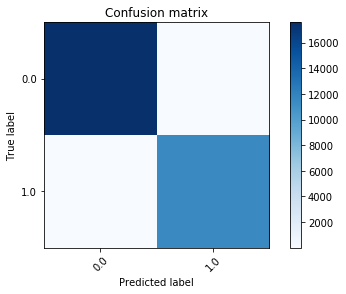

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



In [49]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn, label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(y_true, pred_cnn))

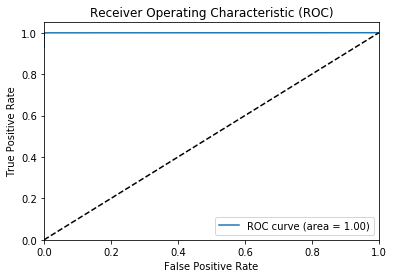

In [50]:
pred_cnn = cnn.predict(x_test_cnn)
pred_cnn = pred_cnn[:,1]
plot_roc(pred_cnn,y_true)

# Comparing F1 Score for all binary classifier models

In [349]:
score_gnb_f1 = 0.9165476101943393
score_f1_log= 0.9876574981204521
score_svm_f1 = 0.9907957550571831

score_nn_f1_sig = 0.9917801405355152
score_knn_f1 = 0.9983171343201566
score_nn_f1_tanh = 0.9984887421783242
score_nn_f1_relu = 0.9986605662844542
score_f1_cnn =  0.9987978721098905

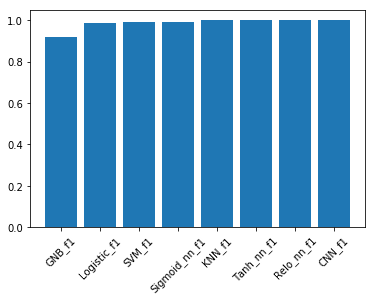

In [350]:
score_list_f1=[score_gnb_f1,score_f1_log, score_svm_f1,score_nn_f1_sig ,
               score_knn_f1,score_nn_f1_tanh,score_nn_f1_relu,score_f1_cnn ]
names =['GNB_f1','Logistic_f1','SVM_f1','Sigmoid_nn_f1','KNN_f1','Tanh_nn_f1',
        'Relo_nn_f1','CNN_f1']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_f1)), score_list_f1)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# Additional Features - feature importance analysis

## Input Perturbation
*** It Uses logloss to evaluate a classification problem  ***

In [181]:
from sklearn import metrics
import scipy as sp
import numpy as np
import math
from sklearn import metrics

def perturbation_rank(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_squared_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

### Logistic

In [221]:
# Rank the features
# from IPython.display import display, HTML

names = list(network_df.columns) # x+y column names
#names.remove("species") # remove the target(y)
rank = perturbation_rank(Log_reg_model, x_test, y_test, names, False)
rank

,name,error,importance
0,dst_host_srv_count,0.189417,1.000000
1,service-private,0.177569,0.937451
2,same_srv_rate,0.123928,0.654262
3,srv_rerror_rate,0.110729,0.584575
4,flag-REJ,0.085873,0.453352
5,count,0.075015,0.396032
6,dst_host_same_srv_rate,0.071307,0.376453
7,flag-S0,0.068210,0.360107
8,hot,0.063496,0.335220
9,dst_host_count,0.052206,0.275616


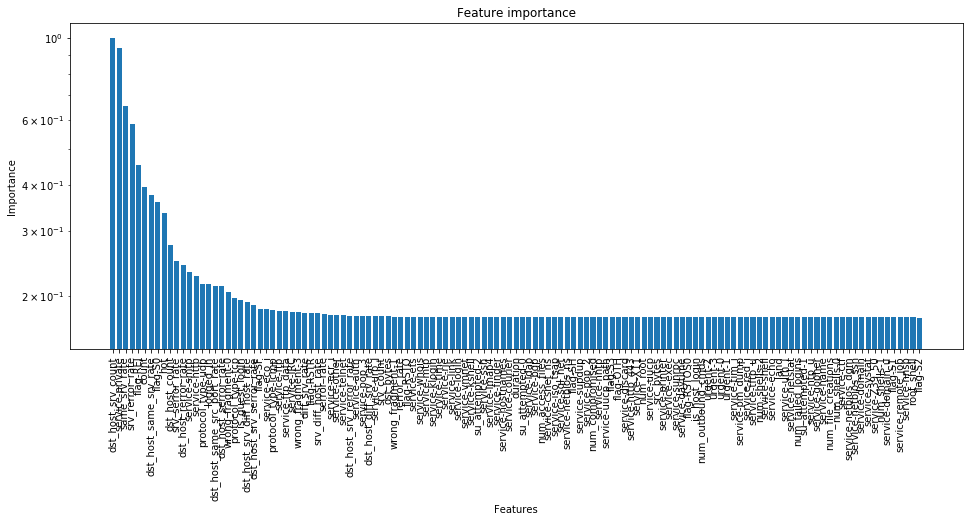

In [230]:

plt.figure(figsize=(16, 6))
plt.yscale('log', nonposy='clip')
plt.bar(range(len(r)), r, align='center')
plt.xticks(range(len(rank['name'])), rank['name'], rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [290]:
rank1 = rank.copy()

In [291]:
rank1 = rank1[rank.importance < .20]

In [294]:
df1 = network_df.copy()

In [296]:
df1.drop(rank1['name'].values, axis=1, inplace= True)

In [301]:
#Split for training and testing
x_train, x_test, y_train, y_test = train_test_split(df1.values, label_outcome_df['outcome'].values, test_size=0.2, random_state=42)

In [302]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(116468, 19)
(116468,)
(29117, 19)
(29117,)


In [303]:
print(x_train)
print(y_train)
print(x_test)
print(y_test)

[[0.         1.         0.02739726 ... 0.         0.         1.        ]
 [0.         0.         0.50097847 ... 0.         0.         1.        ]
 [0.         1.         0.01174168 ... 0.         0.         1.        ]
 ...
 [0.         0.         0.10763209 ... 0.         1.         1.        ]
 [0.         0.         0.47553816 ... 0.         0.         1.        ]
 [0.         1.         0.01369863 ... 0.         0.         1.        ]]
[0. 1. 0. ... 1. 1. 0.]
[[0.         1.         0.01174168 ... 0.         0.         1.        ]
 [0.         0.         1.         ... 1.         0.         1.        ]
 [0.         1.         0.04109589 ... 0.         0.         1.        ]
 ...
 [0.         0.         0.9432485  ... 0.         0.         1.        ]
 [0.         0.         0.4853229  ... 0.         1.         1.        ]
 [0.         0.         0.4324853  ... 0.         1.         1.        ]]
[0. 1. 0. ... 1. 1. 1.]


 ### *** Implementing Logistic Model with 19 important features *** 

In [304]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_train, y_train)

y_pred_logistic = Log_reg_model.predict(x_test)

*** OLd Logistic Model Scores - Number of Feature Inputs - 127  vs 19

In [215]:
# Metrics
from sklearn import metrics
score_acc_log = metrics.accuracy_score(y_test, y_pred_logistic)
print("Accuracy score: {}".format(score_acc_log))

score_precision_log = metrics.precision_score(y_test, y_pred_logistic, average= "weighted")
print("Precision score: {}".format(score_precision_log))

score_recall_log = metrics.recall_score(y_test, y_pred_logistic, average= "weighted")
print("Recall score: {}".format(score_recall_log))

score_f1_log = metrics.f1_score(y_test, y_pred_logistic, average= "weighted")
print("F1 score: {}".format(score_f1_log))

Accuracy score: 0.9876704330803311
Precision score: 0.9876904121704341
Recall score: 0.9876704330803311
F1 score: 0.9876574981204521


In [306]:
# Metrics
from sklearn import metrics
score_acc_log = metrics.accuracy_score(y_test, y_pred_logistic)
print("Accuracy score: {}".format(score_acc_log))

score_precision_log = metrics.precision_score(y_test, y_pred_logistic, average= "weighted")
print("Precision score: {}".format(score_precision_log))

score_recall_log = metrics.recall_score(y_test, y_pred_logistic, average= "weighted")
print("Recall score: {}".format(score_recall_log))

score_f1_log = metrics.f1_score(y_test, y_pred_logistic, average= "weighted")
print("F1 score: {}".format(score_f1_log))

Accuracy score: 0.9856097812274616
Precision score: 0.9856174290684699
Recall score: 0.9856097812274616
F1 score: 0.9855969338792709


In [307]:
logistic_cm = confusion_matrix(y_test, y_pred_logistic)
print(logistic_cm)

[[17438   151]
 [  268 11260]]


Plotting confusion matrix


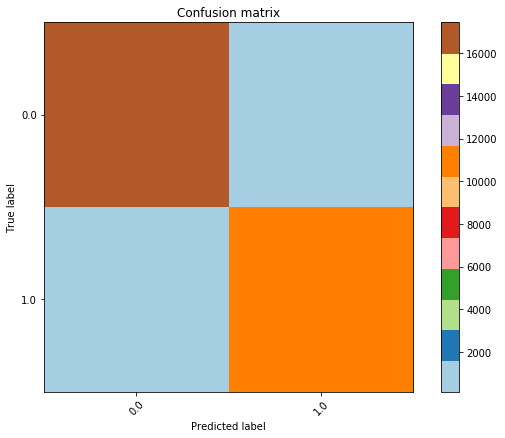

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99     17589
        1.0       0.99      0.98      0.98     11528

avg / total       0.99      0.99      0.99     29117



In [308]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(logistic_cm,label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(y_test, y_pred_logistic))

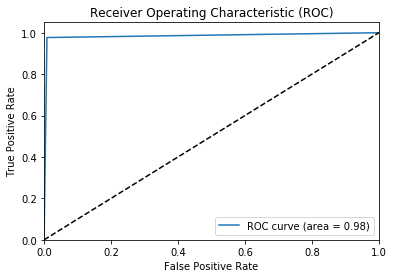

In [305]:
plot_roc(y_pred_logistic,y_test)

In [218]:
y_test.shape

(29117,)

In [219]:
for i in range(100):
    print(" Actual Value: {}, predicted Value: {}".format(y_test[i],y_pred_logistic[i]))

 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1.0, predicted Value: 1.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 0.0, predicted Value: 0.0
 Actual Value: 1

##  ExtraTreesClassifier

In [232]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

extraTreeClassifier = ExtraTreesClassifier()
extraTreeClassifier.fit(network_df, label_outcome_df['outcome'])

# display the relative importance of each attribute

print(extraTreeClassifier.feature_importances_)

[9.34293056e-04 1.14299241e-02 2.33945323e-03 4.86301804e-06
 1.01481963e-02 4.59037828e-05 7.19282115e-02 6.62363080e-03
 2.26317056e-04 2.88989034e-04 1.01225787e-04 6.00768630e-05
 0.00000000e+00 0.00000000e+00 8.56750736e-04 5.72811684e-03
 3.98901474e-03 7.26140478e-02 1.52353449e-02 1.07724428e-03
 1.75678092e-02 1.16954709e-01 5.50902173e-04 3.86763837e-03
 2.48034790e-02 1.45671730e-01 7.34088180e-03 2.18201477e-03
 4.95824137e-03 4.29225064e-03 6.32982611e-02 6.32520111e-02
 3.34004044e-02 6.01120172e-04 1.06718082e-02 7.40463543e-03
 4.34640006e-04 1.60363868e-04 1.13680769e-05 0.00000000e+00
 4.19699960e-05 0.00000000e+00 6.17488691e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.66219983e-06 1.31439824e-05
 6.96247043e-04 0.00000000e+00 1.45794675e-03 5.89768095e-03
 7.37615873e-13 0.00000000e+00 9.30755835e-05 1.92295295e-03
 4.23525994e-03 8.37888343e-06 0.00000000e+00 6.68841620e-03
 1.04640317e-12 5.64844537e-05 6.00828627e-12 1.00603386e-05
 2.24250325e-13 0.000000

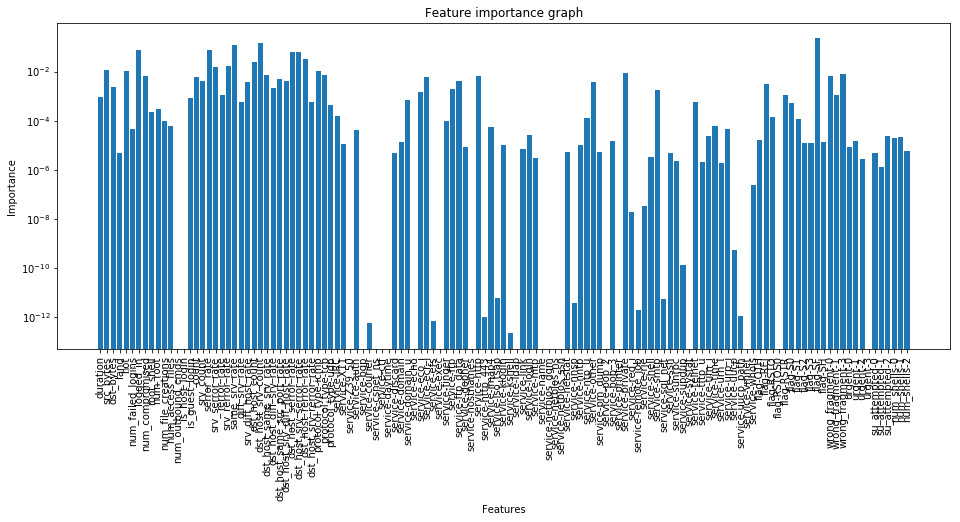

In [233]:
feature_importance = extraTreeClassifier.feature_importances_
plt.figure(figsize=(16, 6))
plt.yscale('log', nonposy='clip')
plt.bar(range(len(feature_importance)), feature_importance, align='center')
plt.xticks(range(len(feature_importance)), network_df, rotation='vertical')
plt.title('Feature importance graph')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [234]:
# Selecting only relevant features

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(extraTreeClassifier, prefit=True)
X_new_features = model.transform(network_df)
feature_idx = model.get_support()
feature_name = network_df.columns[feature_idx]

In [264]:
X_new_features

array([[3.4469051e-07, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [3.3892164e-07, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [3.1584611e-07, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       ...,
       [2.9277061e-07, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [4.1968593e-07, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [3.1584611e-07, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [237]:
print(label_outcome_df.shape)
print(network_df.shape)
print(X_new_features.shape)

(145585, 1)
(145585, 127)
(145585, 16)


In [238]:
#Train test split for feature analysis. Redundancy is removed from data here
x_adf_train, x_adf_test, y_adf_train, y_adf_test = train_test_split(X_new_features, label_outcome_df['outcome'] , test_size=0.2, random_state=42)

In [239]:
print(x_adf_train.shape)
print(y_adf_train.shape)
print(x_adf_test.shape)
print(y_adf_test.shape)

(116468, 16)
(116468,)
(29117, 16)
(29117,)


## Logistic

In [246]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Log_reg_model_adf = LogisticRegression()

Log_reg_model_adf.fit(x_adf_train, y_adf_train)

y_adf_pred_logistic = Log_reg_model_adf.predict(x_adf_test)

In [247]:
# Metrics

score_adf_logistic_acc = metrics.accuracy_score(y_adf_test, y_adf_pred_logistic)
print("Accuracy score: {}".format(score_adf_logistic_acc))

score_adf_logistic_precision = metrics.precision_score(y_adf_test, y_adf_pred_logistic, average= "weighted")
print("Precision score: {}".format(score_adf_logistic_precision))

score_adf_logistic_recall = metrics.recall_score(y_adf_test, y_adf_pred_logistic, average= "weighted")
print("Recall score: {}".format(score_adf_logistic_recall))

score_adf_logistic_f1 = metrics.f1_score(y_adf_test, y_adf_pred_logistic, average= "weighted")
print("F1 score: {}".format(score_adf_logistic_f1))

Accuracy score: 0.973623656283271
Precision score: 0.9736862980308345
Recall score: 0.973623656283271
F1 score: 0.9735682688755668


In [244]:
cm_log_af = confusion_matrix(y_adf_test, y_adf_pred_logistic)
print(cm_log_af)

[[17339   250]
 [  518 11010]]


Plotting confusion matrix


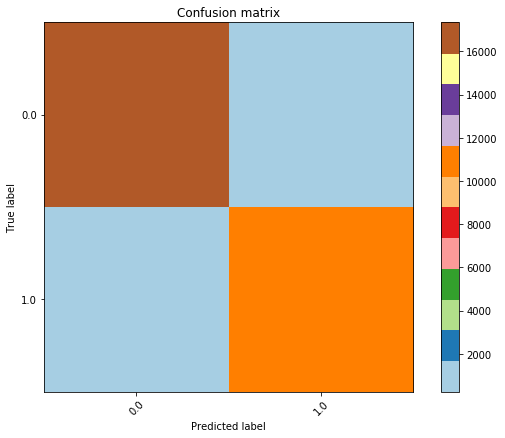

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98     17589
        1.0       0.98      0.96      0.97     11528

avg / total       0.97      0.97      0.97     29117



In [248]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_log_af, label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(y_adf_test, y_adf_pred_logistic))


## Fully Connected Neural Network

In [250]:
outcome_one_hot_df.shape

(145585, 2)

In [251]:

#Split for training and testing
x_train_nn_adf, x_test_nn_adf, y_train_nn_adf, y_test_nn_adf = train_test_split(X_new_features,outcome_one_hot_df.values, test_size=0.2, random_state=42)

In [252]:
print(x_train_nn_adf.shape)
print(y_train_nn_adf.shape)
print(x_test_nn_adf.shape)
print(y_test_nn_adf.shape)

(116468, 16)
(116468, 2)
(29117, 16)
(29117, 2)


In [253]:
# set up checkpointer
checkpoint_relu_nn = ModelCheckpoint(filepath="./best_fully_adf.hdf5", verbose=1, save_best_only=True)


In [259]:
# relu adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_nn_relu_adf = Sequential()
    model_nn_relu_adf.add(Dense(128, input_dim=x_train_nn_adf.shape[1], activation='relu'))
    model_nn_relu_adf.add(Dense(64, activation='relu'))
    model_nn_relu_adf.add(Dense(34, activation='relu'))
    model_nn_relu_adf.add(Dense(8, activation='relu'))
    model_nn_relu_adf.add(Dense(y_test_nn_adf.shape[1],activation='softmax'))
    
    model_nn_relu_adf.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    model_nn_relu_adf.fit(x_train_nn_adf,y_train_nn_adf,batch_size=128,validation_data=(x_test_nn_adf,y_test_nn_adf),callbacks=[monitor,checkpoint_relu_nn ],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_nn_relu_adf.load_weights('./best_fully_adf.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 13s - loss: 0.0595 - val_loss: 0.0298

Epoch 00001: val_loss did not improve from 0.01284
Epoch 2/100
 - 6s - loss: 0.0256 - val_loss: 0.0200

Epoch 00002: val_loss did not improve from 0.01284
Epoch 3/100
 - 8s - loss: 0.0205 - val_loss: 0.0193

Epoch 00003: val_loss did not improve from 0.01284
Epoch 4/100
 - 6s - loss: 0.0190 - val_loss: 0.0217

Epoch 00004: val_loss did not improve from 0.01284
Epoch 5/100
 - 6s - loss: 0.0180 - val_loss: 0.0145

Epoch 00005: val_loss did not improve from 0.01284
Epoch 6/100
 - 8s - loss: 0.0173 - val_loss: 0.0146

Epoch 00006: val_loss did not improve from 0.01284
Epoch 7/100
 - 7s - loss: 0.0163 - val_loss: 0.0140

Epoch 00007: val_loss did not improve from 0.01284
Epoch 8/100
 - 5s - loss: 0.0159 - val_loss: 0.0172

Epoch 00008: val_loss did not improve from 0.01284
Epoch 00008: early stopping
1
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 11s - loss: 0.0646

 - 19s - loss: 0.0590 - val_loss: 0.0276

Epoch 00001: val_loss did not improve from 0.01284
Epoch 2/100
 - 10s - loss: 0.0251 - val_loss: 0.0176

Epoch 00002: val_loss did not improve from 0.01284
Epoch 3/100
 - 11s - loss: 0.0206 - val_loss: 0.0169

Epoch 00003: val_loss did not improve from 0.01284
Epoch 4/100
 - 11s - loss: 0.0187 - val_loss: 0.0170

Epoch 00004: val_loss did not improve from 0.01284
Epoch 5/100
 - 7s - loss: 0.0177 - val_loss: 0.0144

Epoch 00005: val_loss did not improve from 0.01284
Epoch 6/100
 - 6s - loss: 0.0174 - val_loss: 0.0220

Epoch 00006: val_loss did not improve from 0.01284
Epoch 7/100
 - 9s - loss: 0.0169 - val_loss: 0.0163

Epoch 00007: val_loss did not improve from 0.01284
Epoch 8/100
 - 8s - loss: 0.0163 - val_loss: 0.0165

Epoch 00008: val_loss did not improve from 0.01284
Epoch 00008: early stopping
Training finished...Loading the best model



ValueError: Dimension 1 in both shapes must be equal, but are 34 and 32. Shapes are [64,34] and [64,32]. for 'Assign_34' (op: 'Assign') with input shapes: [64,34], [64,32].

In [260]:
# Measure accuracy
pred_nn_relu_adf = model_nn_relu_adf.predict(x_test_nn_adf)
pred_nn_relu_adf = np.argmax(pred_nn_relu_adf,axis=1)
actual_nn_relu_adf = np.argmax(y_test_nn_adf,axis=1)

In [261]:
# Metrics

score_nn_acc_relu_adf = metrics.accuracy_score(actual_nn_relu_adf, pred_nn_relu_adf)
print("Accuracy score: {}".format(score_nn_acc_relu_adf))

score_nn_precision_relu_adf = metrics.precision_score(actual_nn_relu_adf, pred_nn_relu_adf, average= "weighted")
print("Precision score: {}".format(score_nn_precision_relu_adf))

score_nn_recall_relu_adf = metrics.recall_score(actual_nn_relu_adf, pred_nn_relu_adf, average= "weighted")
print("Recall score: {}".format(score_nn_recall_relu_adf))

score_nn_f1_relu_adf = metrics.f1_score(actual_nn_relu_adf, pred_nn_relu_adf, average= "weighted")
print("F1 score: {}".format(score_nn_f1_relu_adf))



Accuracy score: 0.9939210770340351
Precision score: 0.9939605367609616
Recall score: 0.9939210770340351
F1 score: 0.9939142220352817


[[17574    15]
 [  162 11366]]
Plotting confusion matrix


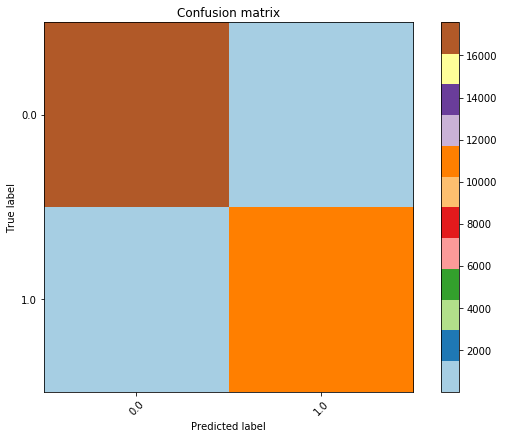

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     17589
          1       1.00      0.99      0.99     11528

avg / total       0.99      0.99      0.99     29117



In [262]:
cm_nn_relu_adf = confusion_matrix(actual_nn_relu_adf, pred_nn_relu_adf)
print(cm_nn_relu_adf)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_nn_relu_adf,label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(actual_nn_relu_adf,pred_nn_relu_adf))


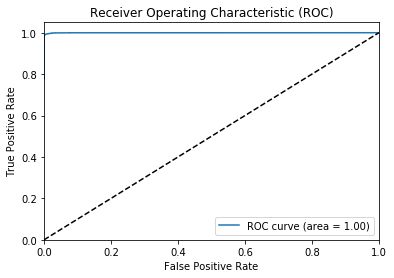

In [263]:
pred_nn_relu_adf = model_nn_relu_adf.predict(x_test_nn_adf)
pred_nn_relu_adf = pred_nn_relu_adf[:,1]
plot_roc(pred_nn_relu_adf,actual_nn_relu_adf)

# multi-class classification

In [51]:
print(network_df.shape)
print(network_outcome_df.shape)

(145585, 127)
(145585, 1)


In [54]:
df = network_outcome_df.copy()

In [70]:
network_outcome_df.outcome.value_counts()

normal.             87831
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: outcome, dtype: int64

In [68]:
df.replace('back.', 'DOS',inplace =True) 
df.replace('buffer_overflow.', 'U2R',inplace =True) 
df.replace('ftp_write.', 'R2L',inplace =True) 
df.replace('guess_passwd.', 'R2L',inplace =True) 
df.replace('imap.', 'R2L',inplace =True) 
df.replace('ipsweep.', 'Probing',inplace =True) 
df.replace('land.', 'DOS',inplace =True) 
df.replace('loadmodule.', 'U2R',inplace =True) 
df.replace('multihop.', 'R2L',inplace =True) 
df.replace('neptune.', 'DOS',inplace =True) 
df.replace('nmap.', 'Probing',inplace =True) 
df.replace('perl.', 'U2R',inplace =True) 
df.replace('phf.', 'R2L',inplace =True) 
df.replace('pod.', 'DOS',inplace =True) 
df.replace('portsweep.', 'Probing',inplace =True) 
df.replace('rootkit.', 'U2R',inplace =True) 
df.replace('satan.', 'Probing',inplace =True) 
df.replace('smurf.', 'DOS',inplace =True) 
df.replace('spy.', 'R2L',inplace =True) 
df.replace('teardrop.', 'DOS',inplace =True) 
df.replace('warezclient.', 'R2L',inplace =True) 
df.replace('warezmaster.', 'R2L',inplace =True) 
df.replace('normal.', 'NONE',inplace =True) 


In [286]:
# label Encoding the output feature for classification models
outcome_label = encode_text_index(outcome_label,'outcome')

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [75]:
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['outcome'])

In [77]:
df.label.value_counts()

1    87831
0    54572
2     2131
3      999
4       52
Name: label, dtype: int64

In [369]:
#printing the labels to be predicted
le_name_mapping1 = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping1)

{'DOS': 0, 'NONE': 1, 'Probing': 2, 'R2L': 3, 'U2R': 4}


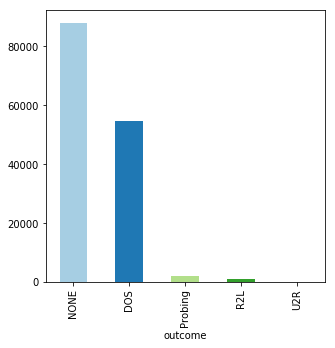

In [73]:
df.outcome.groupby(df.outcome).count().sort_values()[::-1].plot(kind="bar",figsize=(5, 5),color=[plt.cm.Paired(np.arange(len(df['outcome'])))])

In [79]:
#Split for training and testing
x_train_mc, x_test_mc, y_train_mc, y_test_mc = train_test_split(network_df, df['label'], test_size=0.2, random_state=42)


In [80]:
print(x_train_mc.shape)
print(y_train_mc.shape)
print(x_test_mc.shape)
print(y_test_mc.shape)

(116468, 127)
(116468,)
(29117, 127)
(29117,)


## Logistic

In [81]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Log_reg_model_mc = LogisticRegression()

Log_reg_model_mc.fit(x_train_mc, y_train_mc)

y_pred_logistic_mc = Log_reg_model_mc.predict(x_test_mc)


In [97]:
#printing the first 10 actual values and predicted values
for i in range(5):
    indx = y_test_mc.index[i]
    print(" Actual Category - %s    Actual Label -  %s   Predicted - %s" 
          %(df['outcome'][indx], df['label'][indx], (y_pred_logistic_mc[i])))


 Actual Category - NONE    Actual Label -  1   Predicted - 1
 Actual Category - Probing    Actual Label -  2   Predicted - 2
 Actual Category - NONE    Actual Label -  1   Predicted - 1
 Actual Category - DOS    Actual Label -  0   Predicted - 0
 Actual Category - NONE    Actual Label -  1   Predicted - 1


In [370]:
#printing the first 10 actual values and predicted values
for i in range(1000,1050):
    indx = y_test_mc.index[i]
    print(  "Outcome -   %s   Actual-Category   - %s   Predicted Category   - %s  Predicted Label   - %s" 
          %(network_outcome_df['outcome'][indx], df['outcome'][indx],
            le.inverse_transform(y_pred_logistic_mc[i]),y_pred_logistic_mc[i]))

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is a

Outcome -   neptune.   Actual-Category   - DOS   Predicted Category   - DOS  Predicted Label   - 0
Outcome -   normal.   Actual-Category   - NONE   Predicted Category   - NONE  Predicted Label   - 1
Outcome -   normal.   Actual-Category   - NONE   Predicted Category   - NONE  Predicted Label   - 1
Outcome -   neptune.   Actual-Category   - DOS   Predicted Category   - DOS  Predicted Label   - 0
Outcome -   normal.   Actual-Category   - NONE   Predicted Category   - NONE  Predicted Label   - 1
Outcome -   normal.   Actual-Category   - NONE   Predicted Category   - NONE  Predicted Label   - 1
Outcome -   warezclient.   Actual-Category   - R2L   Predicted Category   - R2L  Predicted Label   - 3
Outcome -   normal.   Actual-Category   - NONE   Predicted Category   - NONE  Predicted Label   - 1
Outcome -   neptune.   Actual-Category   - DOS   Predicted Category   - DOS  Predicted Label   - 0
Outcome -   normal.   Actual-Category   - NONE   Predicted Category   - NONE  Predicted Label   - 1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is a

In [369]:
#printing the labels to be predicted
le_name_mapping1 = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping1)

{'DOS': 0, 'NONE': 1, 'Probing': 2, 'R2L': 3, 'U2R': 4}


In [82]:
# Metrics
from sklearn import metrics
score_acc_log_mc = metrics.accuracy_score(y_test_mc, y_pred_logistic_mc)
print("Accuracy score: {}".format(score_acc_log_mc))

score_precision_log_mc = metrics.precision_score(y_test_mc, y_pred_logistic_mc, average= "weighted")
print("Precision score: {}".format(score_precision_log_mc))

score_recall_log_mc = metrics.recall_score(y_test_mc, y_pred_logistic_mc, average= "weighted")
print("Recall score: {}".format(score_recall_log_mc))

score_f1_log_mc = metrics.f1_score(y_test_mc, y_pred_logistic_mc, average= "weighted")
print("F1 score: {}".format(score_f1_log_mc))

Accuracy score: 0.9901775595013222
Precision score: 0.9902579750188167
Recall score: 0.9901775595013222
F1 score: 0.9901006078058643


In [174]:

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Paired):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [171]:
logistic_cm_mc = confusion_matrix(y_test_mc, y_pred_logistic_mc)
print(logistic_cm_mc)

[[10754   170     0     0     0]
 [   28 17528    10    23     0]
 [   10    23   392     0     0]
 [    0    16     0   156     0]
 [    1     1     0     4     1]]


Plotting confusion matrix


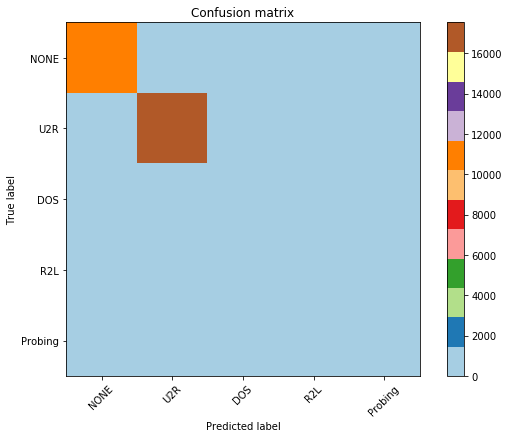

             precision    recall  f1-score   support

          0       1.00      0.98      0.99     10924
          1       0.99      1.00      0.99     17589
          2       0.98      0.92      0.95       425
          3       0.85      0.91      0.88       172
          4       1.00      0.14      0.25         7

avg / total       0.99      0.99      0.99     29117



In [176]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(logistic_cm_mc,df['outcome'].unique())
plt.show()
print(classification_report(y_test_mc, y_pred_logistic_mc))

## Fully Connected

### ReLu 
*** One hot encoding the output feature *** 

In [111]:
outcome_one_hot_df_mc = df.copy()
print(outcome_one_hot_df_mc)

       outcome  label
0         NONE      1
1         NONE      1
2         NONE      1
3         NONE      1
4         NONE      1
5         NONE      1
6         NONE      1
7         NONE      1
8         NONE      1
9         NONE      1
10        NONE      1
11        NONE      1
12        NONE      1
13        NONE      1
14        NONE      1
15        NONE      1
16        NONE      1
17        NONE      1
18        NONE      1
19        NONE      1
20        NONE      1
21        NONE      1
22        NONE      1
23        NONE      1
24        NONE      1
25        NONE      1
26        NONE      1
27        NONE      1
28        NONE      1
29        NONE      1
...        ...    ...
493990    NONE      1
493991    NONE      1
493992    NONE      1
493993    NONE      1
493994    NONE      1
493995    NONE      1
493996    NONE      1
493997    NONE      1
493998    NONE      1
493999    NONE      1
494000    NONE      1
494001    NONE      1
494002    NONE      1
494003    

In [112]:
#One hot coding the output feature
encode_text_dummy(outcome_one_hot_df_mc,"outcome")

In [121]:
outcome_one_hot_df_mc.drop(['label'],inplace=True, axis=1)

In [124]:
outcome_one_hot_df_mc

,outcome-DOS,outcome-NONE,outcome-Probing,outcome-R2L,outcome-U2R
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0


In [125]:
#Split for training and testing
x_train_nn_mc, x_test_nn_mc, y_train_nn_mc, y_test_nn_mc = train_test_split(network_df.values,outcome_one_hot_df_mc.values, test_size=0.2, random_state=42)

In [126]:
print(x_train_nn_mc.shape)
print(y_train_nn_mc.shape)
print(x_test_nn_mc.shape)
print(y_test_nn_mc.shape)

(116468, 127)
(116468, 5)
(29117, 127)
(29117, 5)


In [127]:
# set up checkpointer
checkpoint_nn_mc = ModelCheckpoint(filepath="./best_fully_nn_mc.hdf5", verbose=1, save_best_only=True)

In [129]:
y_test_nn_mc.shape[1]

5

In [130]:
# relu adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_nn_relu_mc = Sequential()
    model_nn_relu_mc.add(Dense(128, input_dim=x_train_nn_mc.shape[1], activation='relu'))
    model_nn_relu_mc.add(Dense(64, activation='relu'))
    model_nn_relu_mc.add(Dense(34, activation='relu'))
    model_nn_relu_mc.add(Dense(8, activation='relu'))
    model_nn_relu_mc.add(Dense(y_test_nn_mc.shape[1],activation='softmax'))
    
    model_nn_relu_mc.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    model_nn_relu_mc.fit(x_train_nn_mc,y_train_nn_mc,batch_size=128,validation_data=(x_test_nn_mc,y_test_nn_mc),callbacks=[monitor,checkpoint_nn_mc ],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_nn_relu_mc.load_weights('./best_fully_nn_mc.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 7s - loss: 0.0887 - val_loss: 0.0263

Epoch 00001: val_loss improved from inf to 0.02630, saving model to ./best_fully_nn_mc.hdf5
Epoch 2/100
 - 7s - loss: 0.0156 - val_loss: 0.0084

Epoch 00002: val_loss improved from 0.02630 to 0.00843, saving model to ./best_fully_nn_mc.hdf5
Epoch 3/100
 - 6s - loss: 0.0105 - val_loss: 0.0068

Epoch 00003: val_loss improved from 0.00843 to 0.00680, saving model to ./best_fully_nn_mc.hdf5
Epoch 4/100
 - 4s - loss: 0.0091 - val_loss: 0.0076

Epoch 00004: val_loss did not improve from 0.00680
Epoch 5/100
 - 7s - loss: 0.0083 - val_loss: 0.0090

Epoch 00005: val_loss did not improve from 0.00680
Epoch 6/100
 - 5s - loss: 0.0077 - val_loss: 0.0060

Epoch 00006: val_loss improved from 0.00680 to 0.00601, saving model to ./best_fully_nn_mc.hdf5
Epoch 00006: early stopping
1
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 9s - loss: 0.0935 - val_loss: 0.0176

Epoch 00001: 

 - 6s - loss: 0.0153 - val_loss: 0.0087

Epoch 00002: val_loss did not improve from 0.00542
Epoch 3/100
 - 7s - loss: 0.0105 - val_loss: 0.0118

Epoch 00003: val_loss did not improve from 0.00542
Epoch 4/100
 - 7s - loss: 0.0088 - val_loss: 0.0071

Epoch 00004: val_loss did not improve from 0.00542
Epoch 5/100
 - 8s - loss: 0.0084 - val_loss: 0.0084

Epoch 00005: val_loss did not improve from 0.00542
Epoch 6/100
 - 8s - loss: 0.0074 - val_loss: 0.0096

Epoch 00006: val_loss did not improve from 0.00542
Epoch 7/100
 - 8s - loss: 0.0071 - val_loss: 0.0078

Epoch 00007: val_loss did not improve from 0.00542
Epoch 00007: early stopping
Training finished...Loading the best model



In [133]:
pred_nn_relu_mc = model_nn_relu_mc.predict(x_test_nn_mc)
pred_nn_relu_mc

array([[4.8036450e-06, 9.9997246e-01, 1.9129740e-05, 1.4743101e-06,
        2.2411598e-06],
       [1.3913461e-06, 1.4583944e-05, 9.9998403e-01, 2.0557055e-10,
        3.3907162e-09],
       [3.5553672e-05, 9.9994051e-01, 8.5993133e-06, 1.2462565e-05,
        2.8926424e-06],
       ...,
       [9.9966967e-01, 3.3039393e-04, 2.9951035e-11, 1.9674137e-10,
        3.5042630e-15],
       [9.9999666e-01, 3.3473254e-06, 3.4152514e-11, 9.0500031e-11,
        1.1104601e-16],
       [9.9999583e-01, 4.1254366e-06, 5.3488908e-11, 1.2625212e-10,
        1.9661437e-16]], dtype=float32)

In [134]:
pred_nn_relu_mc = np.argmax(pred_nn_relu_mc,axis=1)
pred_nn_relu_mc

array([1, 2, 1, ..., 0, 0, 0], dtype=int64)

In [135]:
y_test_nn_mc

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [136]:
actual_nn_relu_mc = np.argmax(y_test_nn_mc,axis=1)
actual_nn_relu_mc

array([1, 2, 1, ..., 0, 0, 0], dtype=int64)

In [365]:
#printing the first 10 actual values and predicted values
for i in range(10):
    indx = y_test_mc.index[i]
    print(" Actual Category - %s    Actual Label -  %s   Predicted - %s" 
          %(df['outcome'][indx], actual_nn_relu_mc[i], (pred_nn_relu_mc[i])))


 Actual Category - NONE    Actual Label -  1   Predicted - 1
 Actual Category - Probing    Actual Label -  2   Predicted - 2
 Actual Category - NONE    Actual Label -  1   Predicted - 1
 Actual Category - DOS    Actual Label -  0   Predicted - 0
 Actual Category - NONE    Actual Label -  1   Predicted - 1
 Actual Category - NONE    Actual Label -  1   Predicted - 1
 Actual Category - NONE    Actual Label -  1   Predicted - 1
 Actual Category - NONE    Actual Label -  1   Predicted - 1
 Actual Category - DOS    Actual Label -  0   Predicted - 0
 Actual Category - DOS    Actual Label -  0   Predicted - 0


In [137]:
# Metrics

#score_log_loss = metrics.log_loss(y_test_nn, model_nn_relu.predict(x_test_nn))
#print("Log Loss: {}".format(score_log_loss))

score_nn_acc_relu_mc = metrics.accuracy_score(actual_nn_relu_mc, pred_nn_relu_mc)
print("Accuracy score: {}".format(score_nn_acc_relu_mc))

score_nn_precision_relu_mc = metrics.precision_score(actual_nn_relu_mc, pred_nn_relu_mc, average= "weighted")
print("Precision score: {}".format(score_nn_precision_relu_mc))

score_nn_recall_relu_mc = metrics.recall_score(actual_nn_relu_mc, pred_nn_relu_mc, average= "weighted")
print("Recall score: {}".format(score_nn_recall_relu_mc))

score_nn_f1_relu_mc = metrics.f1_score(actual_nn_relu_mc, pred_nn_relu_mc, average= "weighted")
print("F1 score: {}".format(score_nn_f1_relu_mc))



Accuracy score: 0.9986949204931826
Precision score: 0.998679582589401
Recall score: 0.9986949204931826
F1 score: 0.9986843974808003


In [138]:
cm_nn_relu_mc = confusion_matrix(actual_nn_relu_mc, pred_nn_relu_mc)
print(cm_nn_relu_mc)

[[10922     2     0     0     0]
 [    2 17576     2     8     1]
 [    1     6   418     0     0]
 [    0    14     0   158     0]
 [    0     1     0     1     5]]


Plotting confusion matrix


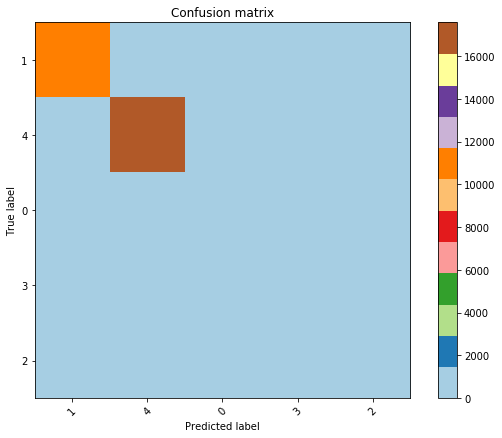

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10924
          1       1.00      1.00      1.00     17589
          2       1.00      0.98      0.99       425
          3       0.95      0.92      0.93       172
          4       0.83      0.71      0.77         7

avg / total       1.00      1.00      1.00     29117



In [179]:
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm_nn_relu_mc,df['label'].unique())
plt.show()
print(classification_report(actual_nn_relu_mc,pred_nn_relu_mc))

## CNN

In [332]:
#Split for training and testing
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = train_test_split(network_df.values,outcome_one_hot_df_mc.values, test_size=0.2, random_state=42)

In [333]:
print(x_train_cnn.shape)
print(y_train_cnn.shape)
print(x_test_cnn.shape)
print(y_test_cnn.shape)

(116468, 127)
(116468, 5)
(29117, 127)
(29117, 5)


In [334]:
# reshaping the x_train and x_test to image form to be used in CNN 2D
x_train_cnn = x_train_cnn.reshape(x_train_cnn.shape[0], 1, x_train_cnn.shape[1], 1)
x_test_cnn = x_test_cnn.reshape(x_test_cnn.shape[0], 1, x_test_cnn.shape[1], 1)

In [335]:
print(x_train_cnn.shape)
print(y_train_cnn.shape)
print(x_test_cnn.shape)
print(y_test_cnn.shape)

(116468, 1, 127, 1)
(116468, 5)
(29117, 1, 127, 1)
(29117, 5)


In [336]:
print(x_train_cnn)
print(y_train_cnn)

[[[[0.0000000e+00]
   [2.9853948e-07]
   [1.4954996e-04]
   ...
   [1.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]


 [[[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [1.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]


 [[[0.0000000e+00]
   [4.0237930e-07]
   [1.4266407e-03]
   ...
   [1.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]


 ...


 [[[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [1.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]


 [[[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [1.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]


 [[[0.0000000e+00]
   [1.2316556e-06]
   [0.0000000e+00]
   ...
   [1.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]]
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [337]:
checkpoint_cnn = ModelCheckpoint(filepath="./best_weights_cnn.hdf5", verbose=1, save_best_only=True)


In [338]:
#input_shape: should be the shape of 1 sample i.e [rows,cols,1]
input_shape = x_train_cnn[0].shape
input_shape

(1, 127, 1)

In [339]:
# CNN 2D

for i in range(3):
    print(i)

    cnn = Sequential()

# Building Conv2D layer 1
    cnn.add(Conv2D(32, kernel_size=(1,3), strides=(1,1), padding='valid',
                     activation='relu',
                     input_shape=input_shape))
# Max pool layer
    cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))    
    
    
# Building Conv2D layer 2
    cnn.add(Conv2D(64, kernel_size=(1,3),strides=(1, 1), activation='relu'))
# Max pool layer
    cnn.add(MaxPooling2D(pool_size=(1,2), strides=None))

# Drop out layer 
    cnn.add(Dropout(0.25))
    
# Flatten
    cnn.add(Flatten())
    
# Fully Connected layer 1

    cnn.add(Dense(128, activation='relu'))
    
# Drop out layer
    cnn.add(Dropout(0.30))
    
    
# Fully Connected layer 2

    cnn.add(Dense(64, activation='relu'))
# Drop out layer
    cnn.add(Dropout(0.50))
    
# output Layer
    cnn.add(Dense(5, activation='softmax'))

# Compile

    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    cnn.fit(x_train_cnn, y_train_cnn, 
            batch_size=128, 
            callbacks=[monitor,checkpoint_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test_cnn, y_test_cnn))

print('Training finished') 
print()
cnn.load_weights('./best_weights_cnn.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 51s - loss: 0.0929 - acc: 0.9772 - val_loss: 0.0370 - val_acc: 0.9897

Epoch 00001: val_loss improved from inf to 0.03698, saving model to ./best_weights_cnn.hdf5
Epoch 2/10
 - 41s - loss: 0.0314 - acc: 0.9906 - val_loss: 0.0113 - val_acc: 0.9968

Epoch 00002: val_loss improved from 0.03698 to 0.01127, saving model to ./best_weights_cnn.hdf5
Epoch 3/10
 - 39s - loss: 0.0169 - acc: 0.9953 - val_loss: 0.0075 - val_acc: 0.9978

Epoch 00003: val_loss improved from 0.01127 to 0.00749, saving model to ./best_weights_cnn.hdf5
Epoch 4/10
 - 39s - loss: 0.0143 - acc: 0.9962 - val_loss: 0.0080 - val_acc: 0.9976

Epoch 00004: val_loss did not improve from 0.00749
Epoch 5/10
 - 40s - loss: 0.0134 - acc: 0.9965 - val_loss: 0.0070 - val_acc: 0.9978

Epoch 00005: val_loss improved from 0.00749 to 0.00696, saving model to ./best_weights_cnn.hdf5
Epoch 6/10
 - 39s - loss: 0.0123 - acc: 0.9968 - val_loss: 0.0079 - val_acc: 0.9979

Epoch 

In [340]:
cnn.load_weights('./best_weights_cnn.hdf5')

In [341]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 1, 125, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 62, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 60, 64)         6208      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 30, 64)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 30, 64)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_194 (Dense)            (None, 128)               245888    
__________

In [342]:
# Evaluate Accuracy in Keras
score_cnn = cnn.evaluate(x_test_cnn, y_test_cnn, verbose=1)
score_cnn

29117/29117 [==============================] - 11s 394us/step


[0.006293350717358353, 0.9984545111103479]

In [343]:
pred_cnn = cnn.predict(x_test_cnn)
pred_cnn = np.argmax(pred_cnn,axis=1)
pred_cnn

array([1, 2, 1, ..., 0, 0, 0], dtype=int64)

In [344]:
y_true = np.argmax(y_test_cnn,axis=1)
y_true

array([1, 2, 1, ..., 0, 0, 0], dtype=int64)

In [345]:
# Metrics

score_acc_cnn = metrics.accuracy_score(y_true, pred_cnn)
print("Accuracy score: {}".format(score_acc_cnn))

score_precision_cnn = metrics.precision_score(y_true, pred_cnn, average= "weighted")
print("Precision score: {}".format(score_precision_cnn))

score_recall_cnn = metrics.recall_score(y_true, pred_cnn, average= "weighted")
print("Recall score: {}".format(score_recall_cnn))

score_f1_cnn = metrics.f1_score(y_true, pred_cnn, average= "weighted")
print("F1 score: {}".format(score_f1_cnn))

Accuracy score: 0.9984545111103479
Precision score: 0.9984660360125963
Recall score: 0.9984545111103479
F1 score: 0.9984518063257809


In [346]:
cm_cnn = confusion_matrix(y_true, pred_cnn)
print(cm_cnn)

[[10924     0     0     0     0]
 [    2 17566     1    18     2]
 [    0     6   418     1     0]
 [    0    11     0   161     0]
 [    0     2     0     2     3]]


In [347]:
label_outcome_df['outcome'].unique()

array([0., 1.])

Plotting confusion matrix


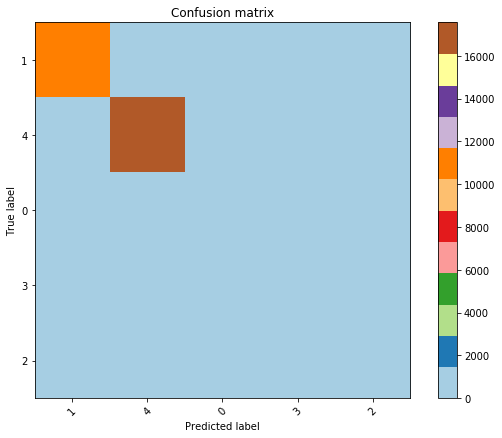

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10924
          1       1.00      1.00      1.00     17589
          2       1.00      0.98      0.99       425
          3       0.88      0.94      0.91       172
          4       0.60      0.43      0.50         7

avg / total       1.00      1.00      1.00     29117



In [348]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn, df['label'].unique())
plt.show()
print(classification_report(y_true, pred_cnn))